In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import fastai.vision as vis
import json
import pandas as pd

ModuleNotFoundError: No module named 'fastai'

# Mnist

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [13]:

def train(model, device, train_loader, optimizer, epoch, log_interval=10):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [14]:

def main():
    # Training settings
#     parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
#     parser.add_argument('--batch-size', type=int, default=64, metavar='N',
#                         help='input batch size for training (default: 64)')
#     parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
#                         help='input batch size for testing (default: 1000)')
#     parser.add_argument('--epochs', type=int, default=10, metavar='N',
#                         help='number of epochs to train (default: 10)')
#     parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
#                         help='learning rate (default: 0.01)')
#     parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
#                         help='SGD momentum (default: 0.5)')
#     parser.add_argument('--no-cuda', action='store_true', default=False,
#                         help='disables CUDA training')
#     parser.add_argument('--seed', type=int, default=1, metavar='S',
#                         help='random seed (default: 1)')
#     parser.add_argument('--log-interval', type=int, default=10, metavar='N',
#                         help='how many batches to wait before logging training status')
    
#     parser.add_argument('--save-model', action='store_true', default=False,
#                         help='For Saving the current Model')
#     args = parser.parse_args()
    
    use_cuda = True
    seed = 1
    batch_size = 64
    test_batch_size = 1000
    lr = 0.01
    momentum = 0.5
    epochs = 10
    
    
    

    torch.manual_seed(seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=test_batch_size, shuffle=True, **kwargs)


    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)

In [15]:
main()

0it [00:00, ?it/s]

9920512it [00:01, 8833722.73it/s]                            


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 112697.10it/s]           
0it [00:00, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 1691996.76it/s]                            
0it [00:00, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 24517.14it/s]            


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300039
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.213470
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.170460
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.076698
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.868078
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.414199
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.000870
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.775734
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.460020
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.486315
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.437761
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.410437
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.462436
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.429283
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.398867
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.386359
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.298190
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.504132
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.522952
Trai

Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.037110
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.150536
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.103741
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.136821
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.139375
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.055201
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.051882
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.029455
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.070305
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.101217
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.028024
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.039556
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.023502
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.040119
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.189941
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.061294
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.045092
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.020520
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.065760
Train Epoch: 2 [56960/60000 (95%)]	Loss: 0.084570


Train Epoch: 4 [29440/60000 (49%)]	Loss: 0.006843
Train Epoch: 4 [30080/60000 (50%)]	Loss: 0.056909
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.008176
Train Epoch: 4 [31360/60000 (52%)]	Loss: 0.031024
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.014604
Train Epoch: 4 [32640/60000 (54%)]	Loss: 0.012996
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.122987
Train Epoch: 4 [33920/60000 (57%)]	Loss: 0.058177
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.086345
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.070779
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.029658
Train Epoch: 4 [36480/60000 (61%)]	Loss: 0.126154
Train Epoch: 4 [37120/60000 (62%)]	Loss: 0.009558
Train Epoch: 4 [37760/60000 (63%)]	Loss: 0.031660
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.009971
Train Epoch: 4 [39040/60000 (65%)]	Loss: 0.011767
Train Epoch: 4 [39680/60000 (66%)]	Loss: 0.053536
Train Epoch: 4 [40320/60000 (67%)]	Loss: 0.148244
Train Epoch: 4 [40960/60000 (68%)]	Loss: 0.011912
Train Epoch: 4 [41600/60000 (69%)]	Loss: 0.036257


Train Epoch: 6 [14080/60000 (23%)]	Loss: 0.029390
Train Epoch: 6 [14720/60000 (25%)]	Loss: 0.006330
Train Epoch: 6 [15360/60000 (26%)]	Loss: 0.011265
Train Epoch: 6 [16000/60000 (27%)]	Loss: 0.017664
Train Epoch: 6 [16640/60000 (28%)]	Loss: 0.013770
Train Epoch: 6 [17280/60000 (29%)]	Loss: 0.012823
Train Epoch: 6 [17920/60000 (30%)]	Loss: 0.057029
Train Epoch: 6 [18560/60000 (31%)]	Loss: 0.023037
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.017896
Train Epoch: 6 [19840/60000 (33%)]	Loss: 0.032576
Train Epoch: 6 [20480/60000 (34%)]	Loss: 0.040755
Train Epoch: 6 [21120/60000 (35%)]	Loss: 0.002050
Train Epoch: 6 [21760/60000 (36%)]	Loss: 0.059166
Train Epoch: 6 [22400/60000 (37%)]	Loss: 0.029860
Train Epoch: 6 [23040/60000 (38%)]	Loss: 0.003365
Train Epoch: 6 [23680/60000 (39%)]	Loss: 0.019203
Train Epoch: 6 [24320/60000 (41%)]	Loss: 0.009740
Train Epoch: 6 [24960/60000 (42%)]	Loss: 0.022513
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.062136
Train Epoch: 6 [26240/60000 (44%)]	Loss: 0.049170


Train Epoch: 7 [58880/60000 (98%)]	Loss: 0.015072
Train Epoch: 7 [59520/60000 (99%)]	Loss: 0.036955

Test set: Average loss: 0.0344, Accuracy: 9874/10000 (99%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.005059
Train Epoch: 8 [640/60000 (1%)]	Loss: 0.005708
Train Epoch: 8 [1280/60000 (2%)]	Loss: 0.009688
Train Epoch: 8 [1920/60000 (3%)]	Loss: 0.012318
Train Epoch: 8 [2560/60000 (4%)]	Loss: 0.055291
Train Epoch: 8 [3200/60000 (5%)]	Loss: 0.027016
Train Epoch: 8 [3840/60000 (6%)]	Loss: 0.027740
Train Epoch: 8 [4480/60000 (7%)]	Loss: 0.005446
Train Epoch: 8 [5120/60000 (9%)]	Loss: 0.002738
Train Epoch: 8 [5760/60000 (10%)]	Loss: 0.009223
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.036166
Train Epoch: 8 [7040/60000 (12%)]	Loss: 0.003865
Train Epoch: 8 [7680/60000 (13%)]	Loss: 0.011327
Train Epoch: 8 [8320/60000 (14%)]	Loss: 0.001035
Train Epoch: 8 [8960/60000 (15%)]	Loss: 0.002302
Train Epoch: 8 [9600/60000 (16%)]	Loss: 0.062373
Train Epoch: 8 [10240/60000 (17%)]	Loss: 0.000917
Train Epoch: 8 [10

Train Epoch: 9 [43520/60000 (72%)]	Loss: 0.005179
Train Epoch: 9 [44160/60000 (74%)]	Loss: 0.002021
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.034356
Train Epoch: 9 [45440/60000 (76%)]	Loss: 0.021294
Train Epoch: 9 [46080/60000 (77%)]	Loss: 0.061924
Train Epoch: 9 [46720/60000 (78%)]	Loss: 0.044986
Train Epoch: 9 [47360/60000 (79%)]	Loss: 0.000978
Train Epoch: 9 [48000/60000 (80%)]	Loss: 0.017952
Train Epoch: 9 [48640/60000 (81%)]	Loss: 0.001292
Train Epoch: 9 [49280/60000 (82%)]	Loss: 0.021845
Train Epoch: 9 [49920/60000 (83%)]	Loss: 0.001988
Train Epoch: 9 [50560/60000 (84%)]	Loss: 0.009009
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.005046
Train Epoch: 9 [51840/60000 (86%)]	Loss: 0.004088
Train Epoch: 9 [52480/60000 (87%)]	Loss: 0.031658
Train Epoch: 9 [53120/60000 (88%)]	Loss: 0.005230
Train Epoch: 9 [53760/60000 (90%)]	Loss: 0.033167
Train Epoch: 9 [54400/60000 (91%)]	Loss: 0.002174
Train Epoch: 9 [55040/60000 (92%)]	Loss: 0.059128
Train Epoch: 9 [55680/60000 (93%)]	Loss: 0.013264


In [19]:
path = vis.untar_data(vis.URLs.MNIST_SAMPLE)
path

PosixPath('/home/adam/.fastai/data/mnist_sample')

In [41]:
transforms = vis.get_transforms(do_flip=False, max_zoom=1)
data = vis.ImageDataBunch.from_folder(path, ds_tfms=transforms, bs=64)
data.normalize(vis.mnist_stats)
img, label = data.train_ds[0]
img

In [42]:
learn = vis.cnn_learner(data, vis.models.resnet18, metrics=vis.accuracy)
learn.fit_one_cycle(1, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.050823,0.022640,0.994603,00:04


In [32]:
vis.accuracy(*learn.get_preds())

tensor(0.9941)

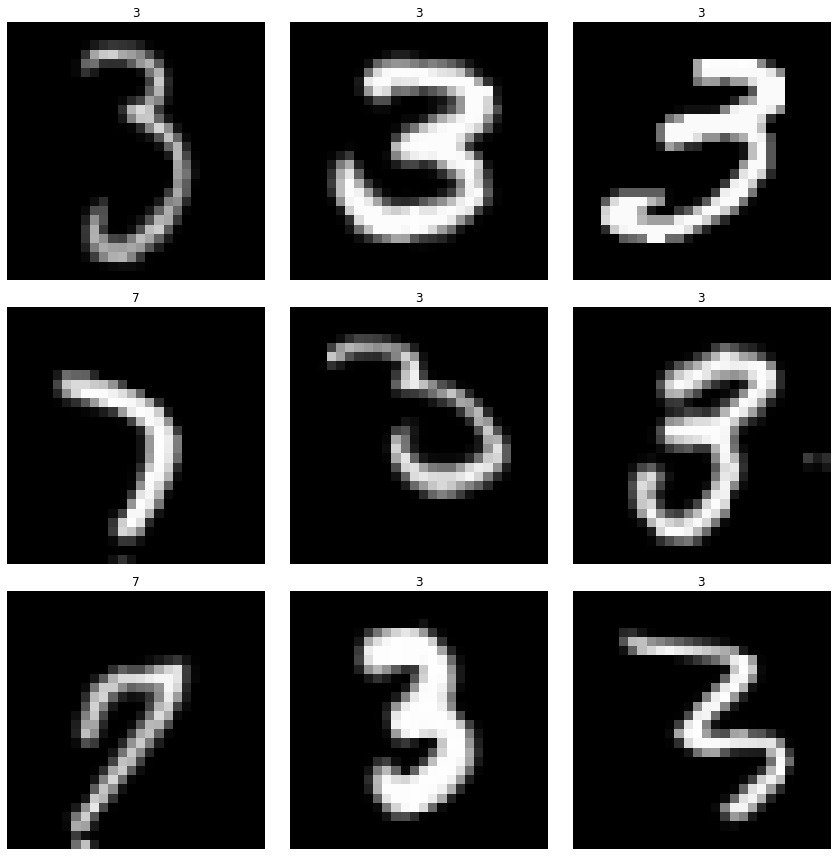

In [43]:
data.show_batch(rows=3)

# COCO

In [4]:
path = vis.untar_data(vis.URLs.COCO_SAMPLE)
path

PosixPath('/home/adam/.fastai/data/coco_sample')

In [5]:
transforms = vis.get_transforms()
data = vis.ImageDataBunch.from_folder(path, ds_tfms=transforms, bs=32)
data.normalize()
img, label = data.train_ds[0]
img

/home/adam/.local/share/virtualenvs/data-I7nS9QO2/lib/python3.6/site-packages/fastai/data_block.py:451: UserWarning: Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.
  warn("Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.")
/home/adam/.local/share/virtualenvs/data-I7nS9QO2/lib/python3.6/site-packages/fastai/data_block.py:454: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


IndexError: index 0 is out of bounds for axis 0 with size 0

In [6]:
path = vis.untar_data(vis.URLs.COCO_SAMPLE)
path.ls()

[PosixPath('/home/adam/.fastai/data/coco_sample/annotations'),
 PosixPath('/home/adam/.fastai/data/coco_sample/train_sample')]

In [54]:
vis.ImageList.from_folder(path/"train_sample").split_none().label_from_func()

TypeError: label_from_func() missing 1 required positional argument: 'func'

In [7]:
l = json.load((path/"annotations/train_sample.json").open())
l

{'categories': [{'id': 62, 'name': 'chair'},
  {'id': 63, 'name': 'couch'},
  {'id': 72, 'name': 'tv'},
  {'id': 75, 'name': 'remote'},
  {'id': 84, 'name': 'book'},
  {'id': 86, 'name': 'vase'}],
 'annotations': [{'image_id': 318219,
   'bbox': [505.24, 0.0, 47.86, 309.25],
   'category_id': 72},
  {'image_id': 318219,
   'bbox': [470.68, 0.0, 45.93, 191.86],
   'category_id': 72},
  {'image_id': 318219,
   'bbox': [442.51, 0.0, 43.39, 119.87],
   'category_id': 72},
  {'image_id': 554625,
   'bbox': [380.74, 112.85, 40.62, 248.82],
   'category_id': 72},
  {'image_id': 554625,
   'bbox': [339.13, 32.99, 32.99, 175.5],
   'category_id': 72},
  {'image_id': 554625,
   'bbox': [359.55, 68.79, 46.02, 202.79],
   'category_id': 72},
  {'image_id': 554625,
   'bbox': [322.48, 0.0, 47.25, 158.32],
   'category_id': 72},
  {'image_id': 554625,
   'bbox': [306.61, 0.33, 28.95, 71.64],
   'category_id': 72},
  {'image_id': 118113,
   'bbox': [284.04, 180.23, 43.78, 14.87],
   'category_id': 84

In [8]:
l.keys()

dict_keys(['categories', 'annotations', 'images'])

In [9]:
a = pd.DataFrame(l["annotations"])
a.head()

,bbox,category_id,image_id
0,"[505.24, 0.0, 47.86, 309.25]",72,318219
1,"[470.68, 0.0, 45.93, 191.86]",72,318219
2,"[442.51, 0.0, 43.39, 119.87]",72,318219
3,"[380.74, 112.85, 40.62, 248.82]",72,554625
4,"[339.13, 32.99, 32.99, 175.5]",72,554625


In [10]:
i = pd.DataFrame(l["images"])
i.head()

,file_name,id
0,000000318219.jpg,318219
1,000000554625.jpg,554625
2,000000118113.jpg,118113
3,000000374628.jpg,374628
4,000000384213.jpg,384213


In [11]:
c = pd.DataFrame(l["categories"])
c.head()

,id,name
0,62,chair
1,63,couch
2,72,tv
3,75,remote
4,84,book


In [14]:
df = a.merge(i, left_on="image_id", right_on="id").drop(columns="id") \
.merge(c, left_on="category_id", right_on="id").drop(columns="id")
df.head()

,bbox,category_id,image_id,file_name,name
0,"[505.24, 0.0, 47.86, 309.25]",72,318219,000000318219.jpg,tv
1,"[470.68, 0.0, 45.93, 191.86]",72,318219,000000318219.jpg,tv
2,"[442.51, 0.0, 43.39, 119.87]",72,318219,000000318219.jpg,tv
3,"[380.74, 112.85, 40.62, 248.82]",72,554625,000000554625.jpg,tv
4,"[339.13, 32.99, 32.99, 175.5]",72,554625,000000554625.jpg,tv


In [21]:
df[["x", "y", "w", "h"]] = df.bbox.apply(pd.Series)

In [27]:
df["area"] = df.w * df.h

In [30]:
df.groupby("image_id")["area"].idxmax()

image_id
30        74470
89        13596
110       59896
113       67175
127       13619
138       73702
164       36244
241       82940
283       37533
315       55557
328       10747
384       85414
397       33841
443       84772
446       84663
536       41831
564       39696
595        2880
599       81409
623       41678
643        5502
711       82062
716       42864
723       63742
762       83744
790       49813
810       31754
909        4924
939         533
941       20731
          ...  
581226    76028
581227    42163
581233    53239
581249     4818
581256    23841
581277    50451
581278    43076
581283     4202
581309    80451
581310    64251
581351    47333
581415    82763
581446    45505
581450    81639
581451    82885
581486    20828
581501    37171
581513     5536
581593    40147
581637    86860
581657    65568
581670    68458
581697    58831
581736     7344
581739    72705
581744     3377
581821    84080
581899    41220
581900    54731
581906    60531
Name: area, Len

In [31]:
df.loc[74470]

bbox           [237.56, 155.81, 166.4, 195.25]
category_id                                 86
image_id                                    30
file_name                     000000000030.jpg
name                                      vase
x                                       237.56
y                                       155.81
w                                        166.4
h                                       195.25
area                                   32489.6
Name: 74470, dtype: object

In [3]:
import numpy as np
import pandas as pd

ModuleNotFoundError: No module named 'pandas'